In [1]:
from skimage.io import imread
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader #alrdy defined
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import matplotlib.patches as patches
import torch
import cv2
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
from IPython.display import clear_output
import random
import seaborn as sns
import torch.utils.data as data #remove this
import copy
import itertools
from torchvision.models import inception_v3
import multiprocessing
from scipy import linalg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
if not os.path.exists('./horse2zebra'):
    import gdown
    url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
    gdown.download(url, './CycleganData.zip', quiet=False)
    !unzip ./CycleganData.zip > /dev/null

Downloading...
From: https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg
To: /content/CycleganData.zip
117MB [00:00, 165MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Dataloader

In [4]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder,subfolder2, transform):
        self.transform = transform
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.input_path2 = os.path.join(image_dir, subfolder2)
        self.image_filenames2 = [x for x in sorted(os.listdir(self.input_path2))]

    def __getitem__(self, index):
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        X = self.transform(img)
        img_fn2 = os.path.join(self.input_path2, self.image_filenames2[index])
        img2 = Image.open(img_fn2).convert('RGB')

        X2 = self.transform(img2)
        return X,X2

    def __len__(self):
        return len(self.image_filenames)

# Data pre-processing
transform = transforms.Compose([transforms.Resize(int(128*1.12), Image.BICUBIC), 
                                transforms.RandomCrop(128), 
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
batchsize = 1

transform_test = transforms.Compose([transforms.Resize(int(128), Image.BICUBIC), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
# Train data
train_data_A = DatasetFromFolder('horse2zebra', subfolder='train/A',subfolder2='train/B', transform=transform)
train_data_loader_AB = torch.utils.data.DataLoader(dataset=train_data_A,batch_size=batchsize,shuffle=True)

# Test data
test_data_A = DatasetFromFolder('horse2zebra', subfolder='test/A',subfolder2='test/B', transform=transform_test)
test_data_loader_AB = torch.utils.data.DataLoader(dataset=test_data_A,batch_size=batchsize,shuffle=False)


tensor(0.)


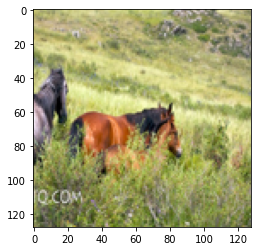

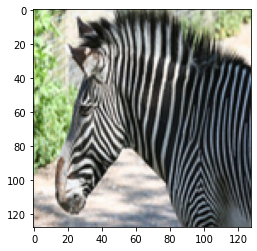

In [5]:
A,B=next(iter(train_data_loader_AB))
plt.figure()
plt.imshow((A[0].permute(1,2,0)+1)/2)
plt.figure()
plt.imshow((B[0].permute(1,2,0)+1)/2)
print(torch.dist(B,B,2))

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden0 = nn.Sequential( 
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128, 256,4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.hidden3 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Sequential(
            torch.nn.Conv2d(512, 1, 4, 1, 1)
        )   

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

    


In [7]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1), nn.Dropout2d(p=0.3))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)
  

# Buffer

In [8]:
class BatchBuffer():
    def __init__(self):
        self.max_size = 50
        self.elements = []

    def __call__(self, data):
        to_return = []
        for element in data:
            element = torch.unsqueeze(element, 0)
            if len(self.elements) < self.max_size:
                self.elements.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    idx = random.randint(0, self.max_size-1)
                    to_return.append(self.elements[idx].clone())
                    self.elements[idx] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return,0))


# Consistency Regularization

In [9]:
import imgaug as ia
from imgaug import augmenters as iaa
def compute_augmentations(original_tensor):
    # Correct dimensions of the image, normalize
    original_batch = original_tensor.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    original_batch = std * original_batch + mean
    #make sure stuff is between 0 and 1
    original_batch = np.clip(original_batch, 0, 1)
    # convert to 0-255 uint8 format for imgaug
    original_batch = original_batch * 255
    original_batch = original_batch.astype("uint8")
 
    augmented_batches = torch.Tensor()
 
    # the sequence of augmentations to apply to the batch of images
    seq2=iaa.Sequential([iaa.Affine(translate_px=(0,3),mode='symmetric'),iaa.Fliplr(p=0.5)])
    aug_batch_numpy = seq2(images=original_batch).astype("float") / 255.
    # normalize
    aug_batch_numpy = (aug_batch_numpy - mean) / std
    # bring to pytorch
    aug_batch_torch = torch.from_numpy(aug_batch_numpy.transpose((0, 3, 1, 2))).float()
    return aug_batch_torch

# Training

In [10]:
# Networks
dA = Discriminator().to(device)
dB = Discriminator().to(device)
gA2B = Generator(blocks=9).to(device)
gB2A = Generator(blocks=9).to(device)

out_dict = {'lossDA': [],
            'lossDB': [],
            'lossa2b': [],
            'lossb2a': [],
            'lossadv': [],
            'lossidt': [],
            'losscyc': [],}

dA.load_state_dict(torch.load("./gdrive/My Drive/net_dA.pt"))
dB.load_state_dict(torch.load("./gdrive/My Drive/net_dB.pt"))
gA2B.load_state_dict(torch.load("./gdrive/My Drive/net_A2B.pt"))
gB2A.load_state_dict(torch.load("./gdrive/My Drive/net_B2A.pt"))

data_file = open("./gdrive/My Drive/data_GAN.pkl", "rb")
out_dict = pickle.load(data_file)
data_file.close()

dA_Cr = Discriminator().to(device)
dB_Cr = Discriminator().to(device)
gA2B_Cr = Generator(blocks=9).to(device)
gB2A_Cr = Generator(blocks=9).to(device)

dA_Cr.load_state_dict(torch.load("./gdrive/My Drive/net_dA_cr.pt"))
dB_Cr.load_state_dict(torch.load("./gdrive/My Drive/net_dB_cr.pt")) 
gA2B_Cr.load_state_dict(torch.load("./gdrive/My Drive/net_A2B_cr.pt"))
gB2A_Cr.load_state_dict(torch.load("./gdrive/My Drive/net_B2A_cr.pt"))

data_file = open("./gdrive/My Drive/data_GAN_cr.pkl", "rb")
out_dict_Cr = pickle.load(data_file)
data_file.close()


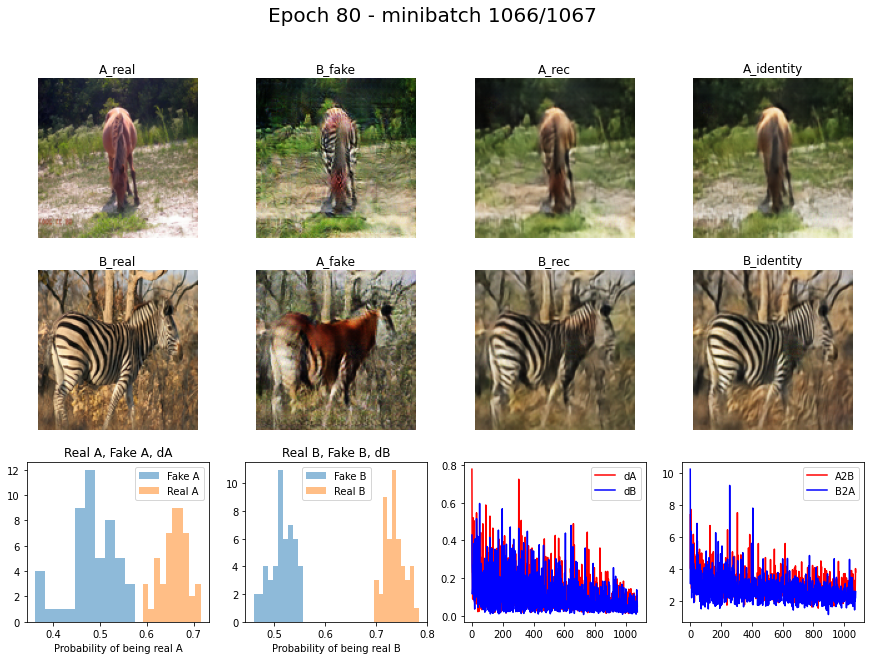

In [ ]:
# Fake image er generated
from IPython import display
from IPython.display import clear_output

# Attributes
lambda_cycle = 10.0
lambda_identity = 5.0
lambda_consistency = 1
num_epochs = 180 
decay_epoch = 100
cr=False

# Optimizers
dA_opt = torch.optim.Adam(dA.parameters(), lr=0.0002, betas=(0.5,0.999))
dB_opt = torch.optim.Adam(dB.parameters(), lr=0.0002, betas=(0.5,0.999),)
g_opt = torch.optim.Adam(itertools.chain(gA2B.parameters(), gB2A.parameters()),
                                lr=0.0002, betas=(0.5, 0.999))

# Losses
MSE_loss = nn.MSELoss()
L1_loss = nn.L1Loss()

# Buffer
B_fake_buffer = BatchBuffer()
A_fake_buffer = BatchBuffer()

# The figure in the loop
plt.figure(figsize=(15,5*2))
subplots = [plt.subplot(3, 4, k+1) for k in range(12)]

for epoch in range(num_epochs):
    if (epoch + 1) > decay_epoch:
      dA_opt.param_groups[0]['lr'] -= 0.0002 / (num_epochs - decay_epoch) #
      dB_opt.param_groups[0]['lr'] -= 0.0002 / (num_epochs - decay_epoch) #
      g_opt.param_groups[0]['lr'] -= 0.0002 / (num_epochs - decay_epoch) #num_epochs - decay_epoch

    for minibatch_no, (A_real, B_real) in enumerate(train_data_loader_AB):
        A_real=Variable(A_real.to(device))
        B_real=Variable(B_real.to(device))

        #Generator A2B
        g_opt.zero_grad()

        B_idt = gA2B(B_real)
        B_id_loss=L1_loss(B_idt, B_real)*lambda_identity

        A_idt = gB2A(A_real)
        A_id_loss=L1_loss(A_idt, A_real)*lambda_identity

        B_fake=gA2B(A_real) 
        dB_fake=dB(B_fake)

        # Generate real and fake labels
        real_label = Variable(torch.ones(dB_fake.size()), requires_grad=False).to(device)
        fake_label = Variable(torch.zeros(dB_fake.size()), requires_grad=False).to(device)

        B_adv_loss = MSE_loss(dB_fake, real_label)

        A_fake=gB2A(B_real) 
        dA_fake=dA(A_fake)
        A_adv_loss = MSE_loss(dA_fake, real_label)
        
        B_rec=gA2B(A_fake) 
        B_cycle_loss = L1_loss(B_rec, B_real)*lambda_cycle

        A_rec=gB2A(B_fake)
        A_cycle_loss = L1_loss(A_rec, A_real)*lambda_cycle 

        g_loss = B_adv_loss+B_cycle_loss+B_id_loss +A_adv_loss+A_cycle_loss+A_id_loss
        g_loss.backward()
        g_opt.step()

        # Discriminator A
        dA.zero_grad()
        dA_real=dA(A_real)
        dA_real_loss = MSE_loss(dA_real, real_label)
        dA_fake_buffer=A_fake_buffer(A_fake)
        dA_fake=dA(dA_fake_buffer.detach())
        dA_fake_loss = MSE_loss(dA_fake, fake_label)

        if(cr==True):
          dA_fake_buffer_t=compute_augmentations(dA_fake_buffer.cpu())
          loss_consistency_A=lambda_consistency*MSE_loss(dA_fake_buffer,dA_fake_buffer_t.to(device))
          dA_loss = (dA_real_loss + dA_fake_loss)*0.5+loss_consistency_A
        else:
          dA_loss = (dA_real_loss + dA_fake_loss)*0.5 

        dA_loss.backward()
        dA_opt.step()
        
        # Discriminator B
        dB.zero_grad()
        dB_real=dB(B_real)
        dB_real_loss = MSE_loss(dB_real, real_label)

        dB_fake_buffer=B_fake_buffer(B_fake)
        dB_fake=dB(dB_fake_buffer.detach())

        dB_fake_loss = MSE_loss(dB_fake, fake_label)

        if(cr==True):
          dB_fake_buffer_t=compute_augmentations(dB_fake_buffer.cpu())
          loss_consistency_B=lambda_consistency*MSE_loss(dB_fake_buffer,dB_fake_buffer_t.to(device))
          dB_loss = (dB_real_loss + dB_fake_loss)*0.5+loss_consistency_B
        else:
          dB_loss = (dB_real_loss + dB_fake_loss)*0.5
        dB_loss.backward()
        dB_opt.step()

        # Get plots and data
        if minibatch_no % 200 == 0:
          out_dict['lossDA'].append(dA_loss.item())
          out_dict['lossDB'].append(dB_loss.item())
          out_dict['lossa2b'].append((B_adv_loss+B_cycle_loss+B_id_loss).item())
          out_dict['lossb2a'].append((A_adv_loss+A_cycle_loss+A_id_loss).item())
          out_dict['losscyc'].append((B_cycle_loss+A_cycle_loss).item())
          out_dict['lossadv'].append((B_adv_loss+A_adv_loss).item())
          out_dict['lossidt'].append((B_id_loss+A_id_loss).item())
    if epoch % 1 == 0:
      print(str(epoch))
      print('DiscriminatorA loss: '+ str(dA_loss.item()))
      print('DiscriminatorB loss: '+ str(dB_loss.item()))
      print('Generator A2B loss: '+ str((B_adv_loss+B_cycle_loss+B_id_loss).item()))
      print('Generator B2A loss: '+ str((A_adv_loss+A_cycle_loss+A_id_loss).item()))
      with torch.no_grad():
        listoffigure=[A_real[0],B_fake[0],A_rec[0],A_idt[0],B_real[0],A_fake[0],B_rec[0],B_idt[0]]
        listofttitles=['A_real','B_fake','A_rec','A_identity','B_real','A_fake','B_rec','B_identity']
        for k in range(0,8):
          subplots[k].imshow((listoffigure[k].permute(1,2,0).cpu()+1)/2)
          subplots[k].set_title(listofttitles[k])
          subplots[k].axis('off')
        subplots[8].cla()
        subplots[8].hist(torch.sigmoid(dA_fake).view(-1).cpu(), label='Fake A',alpha=0.5)
        subplots[8].hist(torch.sigmoid(dA_real).view(-1).cpu(), label='Real A',alpha=0.5)
        subplots[8].set_title('Real A, Fake A, dA')
        subplots[8].set_xlabel('Probability of being real A')
        subplots[8].legend()
        subplots[9].cla()
        subplots[9].hist(torch.sigmoid(dB_fake).view(-1).cpu(), label='Fake B',alpha=0.5)
        subplots[9].hist(torch.sigmoid(dB_real).view(-1).cpu(), label='Real B',alpha=0.5)
        subplots[9].set_title('Real B, Fake B, dB')
        subplots[9].set_xlabel('Probability of being real B')
        subplots[9].legend()
        subplots[10].cla()
        subplots[10].plot(out_dict['lossDA'],'-r',label='dA')
        subplots[10].plot(out_dict['lossDB'],'-b',label='dB')
        subplots[10].legend()
        subplots[11].cla()
        subplots[11].plot(out_dict['lossa2b'],'-r',label='A2B')
        subplots[11].plot(out_dict['lossb2a'],'-b',label='B2A')
        subplots[11].legend()
        titlestr = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_data_loader_AB))
        plt.gcf().suptitle(titlestr, fontsize=20)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    
    # Save models checkpoints
    torch.save(gA2B.state_dict(), './gdrive/My Drive/net_A2B.pt')
    torch.save(gB2A.state_dict(), './gdrive/My Drive/net_B2A.pt')
    torch.save(dA.state_dict(), './gdrive/My Drive/net_dA.pt')
    torch.save(dB.state_dict(), './gdrive/My Drive/net_dB.pt')
    data_file = open("./gdrive/My Drive/data_GAN.pkl", "wb")
    pickle.dump(out_dict, data_file)
    data_file.close()

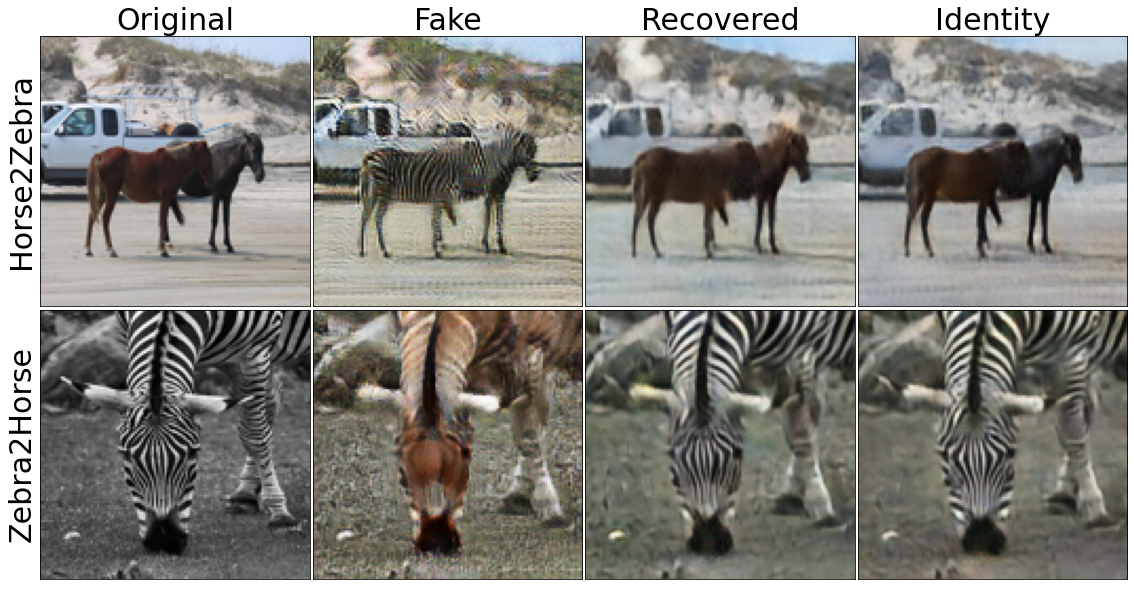

In [11]:
test_data_loader_AB_temp = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=batchsize, shuffle=True)

A,B=next(iter(test_data_loader_AB_temp))
plt.figure(figsize=(17,8))
subplots = [plt.subplot(2, 4, k+1) for k in range(8)]
with torch.no_grad():
  A=A.to(device)
  B_fake=gA2B(A)
  rec_As=gB2A(B_fake)
  ind_A=gB2A(A)
  B=B.to(device)
  fake_As=gB2A(B)
  rec_Bs=gA2B(fake_As)
  ind_B=gA2B(B)
  listoffigure=[A[0],B_fake[0],rec_As[0],ind_A[0],B[0],fake_As[0],rec_Bs[0],ind_B[0]]
  listofttitles=['Original','Fake','Recovered','Identity','','','','']
  for k in range(0,8):
    
    subplots[k].imshow((listoffigure[k].permute(1,2,0).cpu()+1)/2)
    subplots[k].set_title(listofttitles[k],size=30)
    #subplots[k].axis('off')
    subplots[k].set_xticks([])
    subplots[k].set_yticks([])
  subplots[0].set_ylabel('Horse2Zebra',size=30)
  subplots[4].set_ylabel('Zebra2Horse',size=30)
  plt.tight_layout(pad=0.02,w_pad=-10)
  plt.savefig('Result.pdf',bbox_inches='tight')

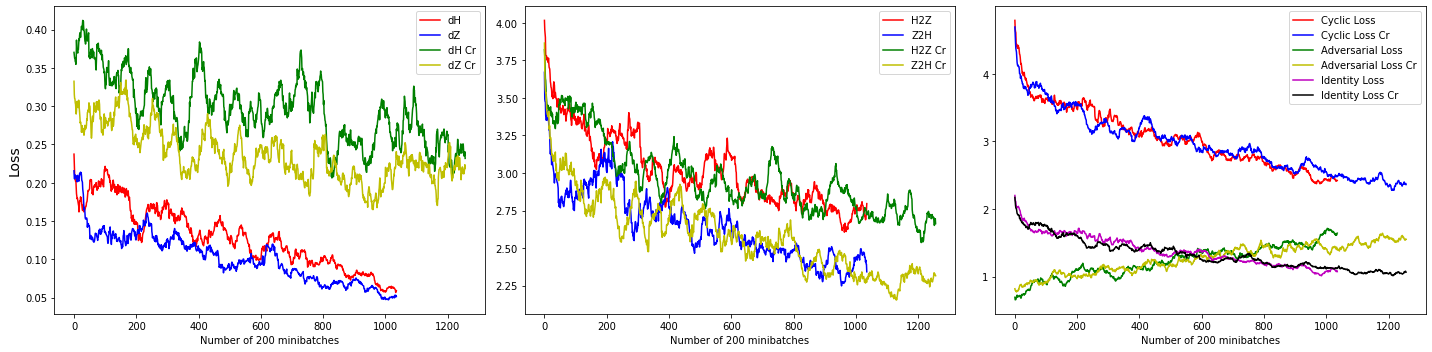

In [12]:
def moving_average(a, n=40) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharex=True)
ax[0].plot(moving_average(out_dict['lossDA']),'-r',label='dH')
ax[0].plot(moving_average(out_dict['lossDB']),'-b',label='dZ')
ax[0].plot(moving_average(out_dict_Cr['lossDA']),'-g',label='dH Cr')
ax[0].plot(moving_average(out_dict_Cr['lossDB']),'-y',label='dZ Cr')
ax[0].legend()
ax[0].set_ylabel("Loss", fontsize=14)
ax[1].plot(moving_average(out_dict['lossa2b']),'-r',label='H2Z')
ax[1].plot(moving_average(out_dict['lossb2a']),'-b',label='Z2H')
ax[1].plot(moving_average(out_dict_Cr['lossa2b']),'-g',label='H2Z Cr')
ax[1].plot(moving_average(out_dict_Cr['lossb2a']),'-y',label='Z2H Cr')
ax[1].legend()
ax[2].plot(moving_average(out_dict['losscyc']),'-r',label='Cyclic Loss')
ax[2].plot(moving_average(out_dict_Cr['losscyc']),'-b',label='Cyclic Loss Cr')
ax[2].plot(moving_average(out_dict['lossadv']),'-g',label='Adversarial Loss')
ax[2].plot(moving_average(out_dict_Cr['lossadv']),'-y',label='Adversarial Loss Cr')
ax[2].plot(moving_average(out_dict['lossidt']),'-m',label='Identity Loss')
ax[2].plot(moving_average(out_dict_Cr['lossidt']),'-k',label='Identity Loss Cr')
ax[2].legend()
ax[0].set_xlabel("Number of 200 minibatches")
ax[1].set_xlabel("Number of 200 minibatches")
ax[2].set_xlabel("Number of 200 minibatches")
fig.tight_layout()
plt.savefig("training.png",bbox_inches='tight')


# Inception score

In [13]:
def to_cuda(elements):
    if torch.cuda.is_available():
        return elements.cuda()
    return elements

class PartialInceptionNetwork(nn.Module):
    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]
        # Trigger output hook
        self.inception_network(x)
        # Output: N x 2048 x 1 x 1 
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations

def get_activations(images, batch_size, inception_network):
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)
    num_images = images.shape[0]
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations

def calculate_activation_statistics(images, batch_size, inception_network):
    """Calculates the statistics used by FID"""
    act = get_activations(images, batch_size, inception_network)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance."""

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def calculate_fid(images1, images2, batch_size, inception_network):
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size, inception_network)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size, inception_network)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

inception_network = PartialInceptionNetwork()
inception_network = to_cuda(inception_network)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [14]:
def get_FID_scores(model_gA2B, model_gB2A):
  FID_scores = {"ZebraToHorse" : [],
                "HorseToZebra" : [],
                "HorseBaseline": [],
                "ZebraBaseline": [],
                "HorseZebraBaseline": [],
  }
  with torch.no_grad():
      for A,B in test_data_loader_AB:
        A=A.to(device) #Horse
        B=B.to(device) #Zebra
        A_train, B_train = next(iter(train_data_loader_AB))
        A_train.to(device)
        B_train.to(device)
        B_fake=F.interpolate(model_gA2B(A),299)
        A_fake=F.interpolate(model_gB2A(B),299)
        A=F.interpolate(A,299)
        B=F.interpolate(B,299)
        A_train=F.interpolate(A_train,299)
        B_train=F.interpolate(B_train,299)

        FID_scores["ZebraToHorse"].append(calculate_fid(A, A_fake, 1, inception_network))
        FID_scores["HorseToZebra"].append(calculate_fid(B, B_fake, 1, inception_network))
        FID_scores["HorseBaseline"].append(calculate_fid(A, A_train, 1, inception_network))
        FID_scores["ZebraBaseline"].append(calculate_fid(B, B_train, 1, inception_network))
        FID_scores["HorseZebraBaseline"].append(calculate_fid(B, A, 1, inception_network))
  return FID_scores

def get_means_stds(FID):
  means = []
  stds = []
  for key in FID:
    means.append(np.mean(FID[key]))
    stds.append(np.std(FID[key]))
  return means, stds

In [15]:
FID_score=get_FID_scores(gA2B, gB2A)
FID_score_cr=get_FID_scores(gA2B_Cr, gB2A_Cr)
FID_mean, FID_std = get_means_stds(FID_score)
FID_mean_cr, FID_std_cr = get_means_stds(FID_score_cr)

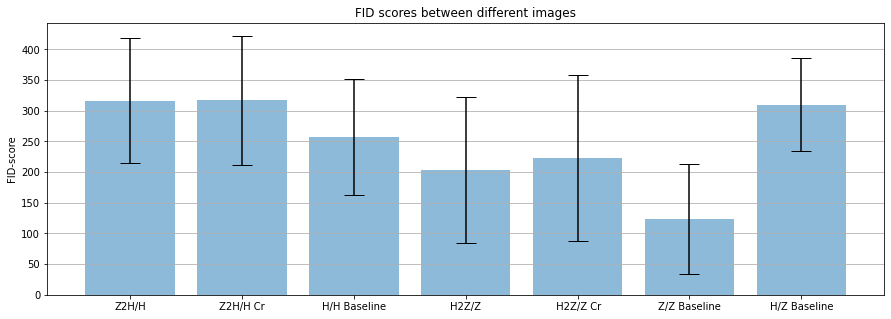

In [16]:
# Define labels, positions, bar heights and error bar heights
labels = ['Z2H/H','Z2H/H Cr',"H/H Baseline", 'H2Z/Z' ,' H2Z/Z Cr', "Z/Z Baseline", "H/Z Baseline"]
x_pos = np.arange(len(labels))
CTEs = [FID_mean[0], FID_mean_cr[0], FID_mean[2], FID_mean[1], FID_mean_cr[1], FID_mean[3], FID_mean[4]]
error = [FID_std[0], FID_std_cr[0], FID_std[2], FID_std[1], FID_std_cr[1], FID_std[3], FID_std[4]]
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('FID-score')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title("FID scores between different images")
ax.yaxis.grid(True)
plt.savefig('fid.png',bbox_inches='tight')